In [51]:
%cd /content/drive/MyDrive/multi/0420

/content/drive/MyDrive/multi/0420


In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy
!pip install tensorflow

In [4]:
from konlpy.tag import Okt
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [5]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

In [6]:
print(f'훈련용 데이터: {train_data.shape}')
print(f'테스트 데이터: {test_data.shape}')

훈련용 데이터: (150000, 3)
테스트 데이터: (50000, 3)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [8]:
# 중복 데이터 제거

len(train_data['document'].unique())

146183

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
len(test_data['document'].unique())

49158

In [11]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [12]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49158 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49158 non-null  int64 
 1   document  49157 non-null  object
 2   label     49158 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [13]:
train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)
test_data.dropna(inplace=True)
test_data.reset_index(drop=True, inplace=True)

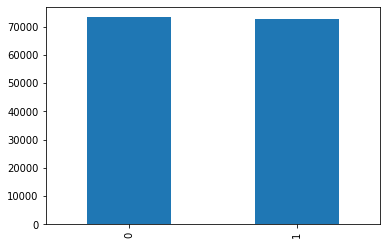

In [14]:
train_data['label'].value_counts().plot.bar()

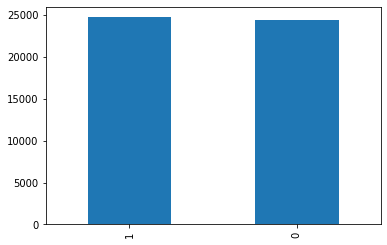

In [15]:
test_data['label'].value_counts().plot.bar()

In [16]:
train_data.isna().sum()

id          0
document    0
label       0
dtype: int64

In [17]:
test_data.isna().sum()

id          0
document    0
label       0
dtype: int64

In [18]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,73342
1,1,72840


In [19]:
train_data['document']=train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
train_data['document']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
146177                                      인간이 문제지 소는 뭔죄인가
146178                                           평점이 너무 낮아서
146179                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
146180                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
146181                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [20]:
train_data = train_data[train_data['document'] != '']
train_data.shape

(145791, 3)

In [21]:
test_data = test_data[test_data['document'] != '']
test_data.shape

(49157, 3)

In [22]:
stopwords = ['의','가','이','은','들','는','좀',
             '잘','걍','과','도','를','으로','자',
             '에','와','한','하다']

x_train = []
okt = Okt()
for doct in train_data['document']:
    # 토큰화
    tmp_x = okt.morphs(doct, stem=True)
    tmp_x = [word for word in tmp_x if word not in stopwords]
    x_train.append(tmp_x)

In [23]:
x_test = []
okt = Okt()
for doct in test_data['document']:
    # 토큰화
    tmp_x = okt.morphs(doct, stem=True)
    tmp_x = [word for word in tmp_x if word not in stopwords]
    x_test.append(tmp_x)

In [ ]:
# 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
tokenizer.word_index

In [25]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [26]:
tokenizer = Tokenizer(total_cnt, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [27]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [29]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]
drop_train[:3]

[404, 412, 470]

In [30]:
# 빈 샘플들을 제거
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(x_train))
print(len(y_train))

145380
145380


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


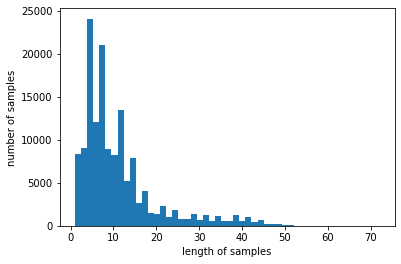

In [32]:
print('리뷰의 최대 길이 :',max(len(l) for l in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [35]:
max_len = 10
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 63.06231943871234


In [43]:
print('시퀀스 패딩(sample * time)')
x_train=sequence.pad_sequences(x_train,maxlen=max_len)
x_test=sequence.pad_sequences(x_test,maxlen=max_len)
print('X_train 크기 :',x_train.shape)
print('X_test 크기 : ', x_test.shape)

시퀀스 패딩(sample * time)
X_train 크기 : (145380, 10)
X_test 크기 :  (49157, 10)


In [44]:
# LSTM 
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(total_cnt, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 검증 데이터 손실(val_loss)이 증가하면, 
# 과적합 징후므로 검증 데이터 손실이 4회 증가하면 
# 학습을 조기 종료(Early Stopping)합니다. 
es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=4)
# ModelCheckpoint를 사용하여 검증 데이터의 
# 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=3, 
                    callbacks=[es, mc], 
                    batch_size=60, 
                    validation_split=0.2)


loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/3
1936/1939 [============================>.] - ETA: 0s - loss: 0.4131 - acc: 0.8087
Epoch 1: val_acc improved from -inf to 0.82869, saving model to best_model.h5
1939/1939 [==============================] - 34s 13ms/step - loss: 0.4131 - acc: 0.8087 - val_loss: 0.3820 - val_acc: 0.8287
Epoch 2/3
1938/1939 [============================>.] - ETA: 0s - loss: 0.3529 - acc: 0.8438
Epoch 2: val_acc improved from 0.82869 to 0.83973, saving model to best_model.h5
1939/1939 [==============================] - 21s 11ms/step - loss: 0.3529 - acc: 0.8438 - val_loss: 0.3643 - val_acc: 0.8397
Epoch 3/3
1936/1939 [============================>.] - ETA: 0s - loss: 0.3235 - acc: 0.8613
Epoch 3: val_acc improved from 0.83973 to 0.84114, saving model to best_model.h5
1537/1537 [==============================] - 8s 5ms/step - loss: 0.3872 - acc: 0.8271

 테스트 정확도: 0.8271


In [46]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = sequence.pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [75]:
sentiment_predict('이거 꿀잼')

96.25% 확률로 긍정 리뷰입니다.



In [77]:
sentiment_predict('이게 영화냐?ㅠㅠ')

88.00% 확률로 부정 리뷰입니다.



In [68]:
sentiment_predict('이 영화 개노잼')

99.29% 확률로 부정 리뷰입니다.

